In [ ]:
from examples.paper.initialize import *
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# Read in Data

In [4]:
data_name = 'german'
data_file = data_dir / ('%s_processed.csv' % data_name)
output_dir = results_dir /  data_name

## load and process data
data_df = pd.read_csv(data_file).reset_index(drop=True)
# german_df = german_df.assign(isMale=lambda df: (df['Gender']=='Male').astype(int))#.drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1)
y = data_df['GoodCustomer']
X = (data_df.drop('GoodCustomer', axis=1)
     .drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1))

# Train classifier

In [6]:
## Train and generate AUCs
## grid search
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
grid = GridSearchCV(
        clf, param_grid={'C': np.logspace(-4, 3)},
        cv=10,
        scoring='roc_auc',
        return_train_score=True
        )
grid.fit(X, y)
clf = grid.best_estimator_

# Create Actionset

In [5]:
## set up actionset
gender_weight = data_df.assign(c = 1).groupby('Gender')['c'].transform(lambda s: s * 1. / len(s))
X_gender_balanced = X.sample(n = len(X)*3, replace=True, weights=gender_weight)
action_set = ActionSet(X = X_gender_balanced)
action_set['Age'].mutable = False
action_set['Single'].mutable = False
action_set['JobClassIsSkilled'].mutable = False
action_set['ForeignWorker'].mutable = False
action_set['OwnsHouse'].mutable = False
action_set['RentsHouse'].mutable = False
action_set['CriticalAccountOrLoansElsewhere'].step_direction = -1
action_set['CheckingAccountBalance_geq_0'].step_direction = 1

# Run Audit

In [10]:
# median score
np.median(clf.predict_proba(X)[:, 1])

0.7204080942839757

In [11]:
# cache classifier
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]
action_set.align(coefficients=coefficients)

# audit
p = .72 ## for now we'll set this to the median score, but we could set this to any threshold we want.
auditor = RecourseAuditor(
    action_set,
    coefficients = coefficients,
    intercept = intercept - (np.log(p / (1. - p))),
)
audit_results = auditor.audit(X = X)

# Visualize

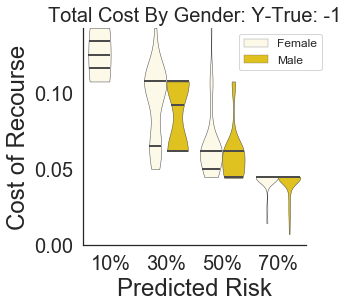

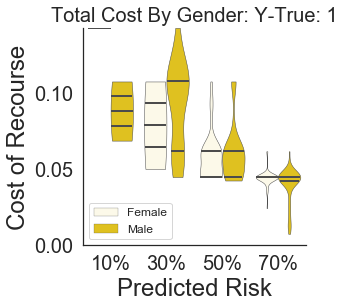

In [17]:
scores = pd.Series(clf.predict_proba(X)[:, 1])
matching_df = pd.concat([
    data_df[['GoodCustomer', 'Gender']],
    audit_results[['cost']],
    scores.to_frame('y_pred')
    ], axis=1).replace(np.inf, np.nan).dropna()


####### Matching 2: Control for Y=+/- 1
matching_df['y_pred_bin'] = pd.cut(
        matching_df['y_pred'],
        bins=np.arange(0, .9, .2)
        )

bins = matching_df['y_pred_bin'].unique()

max_cost = matching_df['cost'].max()
plt.rc("font", size=20)
for y_true in [-1, 1]:
    plt.figure(figsize=(4, 4))
    ax = sns.violinplot(x='y_pred_bin',  y='cost', hue='Gender',
                        data=matching_df.loc[lambda df: df['GoodCustomer'] == y_true].sort_values('Gender'),
                        linewidth = 0.5, cut=0, background='white',
                        scale = 'width', color="gold",  inner = 'quartile')
    # , inner = 'quartile', color = "gold", scale = 'width'
    ax.set_xticklabels(["10%", "30%", "50%", "70%"])#, rotation='vertical')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylim((0, max_cost))
    plt.title('Total Cost By Gender: Y-True: %d' % y_true, fontsize=20)
    plt.ylabel('Cost of Recourse')
    plt.xlabel('Predicted Risk' )

    # plt.legend(bbox_to_anchor=(0.1, .03, .65, .14), ncol=2, mode="expand", borderaxespad=0.)
    # plt.legend(fontsize=14, ncol=2, mode='expand',bbox_to_anchor=(.18, .51, .875, .51), )
    if y_true == -1:
        plt.legend(fontsize=12., loc='upper right', bbox_to_anchor=(1.1, 1))
    else:
        plt.legend(fontsize=12., loc='lower left')#, bbox_to_anchor=(1.1, 1))
    for l in ax.lines:
        l.set_linewidth(2.)
        l.set_linestyle('-')
        l.set_solid_capstyle('butt')

    plt.show() 

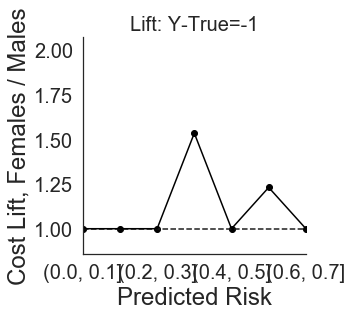

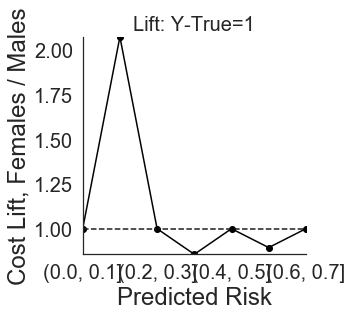

In [19]:
##### Plot Lift
agg_dfs = {}
for y_true in [-1, +1]:
    agg_df = (matching_df
              .loc[lambda df: df['GoodCustomer'] == y_true]
              .pipe(
            lambda df: df.groupby(pd.cut(df['y_pred'], bins=np.arange(0, scores.median(), .1)))
            )
              .apply(lambda df:
                     df.loc[lambda df: df['Gender']=='Female']['cost'].median() /
                     df.loc[lambda df: df['Gender']=='Male']['cost'].median()
                     )
              .fillna(1)
              )
    agg_dfs[y_true] = agg_df

min_, max_ = pd.concat(agg_dfs.values()).pipe(lambda s: (s.min(), s.max()))
for y_true in [-1, +1]:
    # ax = plt.plot(np.arange(len(agg_df)), agg_df.values)
    ax = agg_dfs[y_true].plot(color="black", figsize=(4,4))
    plt.scatter(range(len(agg_dfs[y_true])), agg_dfs[y_true].values, color='black')
    ax.set_facecolor("white")
    plt.ylabel('Cost Lift, Females / Males')
    plt.ylim((min_, max_))
    plt.xlabel('Predicted Risk' )
    plt.hlines(1, *plt.xlim(), linestyles='dashed')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.title('Lift: Y-True=%s' % y_true, fontsize=20)
    xticks = plt.xticks()
    plt.show()

# Generate Flipsets

In [ ]:
# ### get flipset
# # gender = 'Female'
# gender = "Male"
# individuals = (matching_df
#     # .loc[lambda df: df['Gender'] == gender]
#     .loc[lambda df: df['y_pred'] < .4]
#     .loc[lambda df: df['y_pred'] > .2]
#     .loc[lambda df: df['GoodCustomer'] == 1]
#     )
# i = individuals.index[0]

# # i = 815
# i = 818
# action_set = ActionSet(X=X_gender_balanced)
# action_set['Age'].mutable = False
# action_set['Single'].mutable = False
# action_set['JobClassIsSkilled'].mutable = False
# action_set['ForeignWorker'].mutable = False
# action_set['OwnsHouse'].mutable = False
# action_set['RentsHouse'].mutable = False
# action_set['CriticalAccountOrLoansElsewhere'].step_direction = -1
# action_set['CheckingAccountBalance_geq_0'].step_direction = 1

# action_set['NoCurrentLoan'].mutable = False
# action_set['YearsAtCurrentJob_lt_1'].mutable = False
# action_set['YearsAtCurrentHome'].mutable = False
# action_set['SavingsAccountBalance_geq_500'].mutable = False
# action_set['YearsAtCurrentJob_geq_4'].mutable = False

# # actions to switch up actionset
# action_set['HasGuarantor'].mutable = False
# action_set['HasCoapplicant'].mutable = False
# action_set['HasTelephone'].mutable = False
# action_set['OtherLoansAtBank'].mutable = False
# # action_set['LoanAmount'].mutable = False
# action_set['LoanRateAsPercentOfIncome'].mutable = False

# # action_set['LoanDuration'].mutable = False
# # action_set['CheckingAccountBalance_geq_200'].mutable = False
# action_set['NumberOfLiableIndividuals'].mutable = False
# # action_set['SavingsAccountBalance_geq_500'].mutable = False
# # action_set['SavingsAccountBalance_geq_100'].mutable = False
# action_set['Unemployed'].mutable = False

# action_set.align(coefficients=coefficients)

# p = scores.median()
# x = X.values[i]
# rb = RecourseBuilder(
#         coefficients=coefficients,
#         intercept=intercept - (np.log(p / (1. - p))),
#         action_set=action_set,
#         x=x
#         )

# cplex_output = rb.fit()
# if cplex_output['feasible']:
#     full_actionset = []
#     for feature in range(len(x)):
#         orig_val = x[feature]
#         changed_val = (x[feature] + cplex_output['actions'][feature])
#         if not np.isclose(orig_val, changed_val):
#             output = "& \\textit{%s} & " %  X.columns[feature]
#             output += "%f" % orig_val  + " & \\longrightarrow & %f \\\\" % changed_val
#             full_actionset.append(output)
#     print("\n".join(full_actionset))
# else:
#     print("infeasible")